In [1]:
!pip install Unidecode
!pip install fuzzysearch

!pip install elementpath
!pip install lxml 
!pip install graphviz
!pip install pydotplus

In [2]:
!ls ../../edspdf-train/data/publaynet/

dev.json xmls


# Sorting lines based on the xml files

In [3]:
from sort_xml import *
base_dir = '../../edspdf-train/data/publaynet/'

%load_ext autoreload
%autoreload 2

import sys
sys.executable

'/Users/souleymbaye/opt/anaconda3/envs/eds_env/bin/python'

### Load pdf and xml example 

In [4]:
!ls ../../edspdf-train/data/publaynet/xmls | head -n +25

PMC1087887
PMC1087888
PMC1241820
PMC1247186
PMC1247188
PMC1247189
PMC1247474
PMC1247478
PMC1247480
PMC1247485
PMC1247515
PMC1247517
PMC1247523
PMC1247562
PMC1247569
PMC1247570
PMC1247573
PMC1247606
PMC1247607
PMC1247608
PMC1247616
PMC1247620
PMC1247625
PMC1247658
PMC1247661


In [5]:
!ls ../../edspdf-train/data/publaynet/xmls/PMC1247517/

ehp0112-001282.nxml  ehp0112-001282e2.jpg ehp0112-001282f2.gif
ehp0112-001282.pdf   ehp0112-001282f1.gif ehp0112-001282f2.jpg
ehp0112-001282e1.jpg ehp0112-001282f1.jpg


In [ ]:
PMC1247562 # exellent
PMC1247569 # exell b-37 --> (now ok)
PMC1247570 # title twice b-16, b-23
PMC1247573 # front, body et tables perfect
PMC1247606 # between b-7 and b-8, two missing nodes in the xml
PMC1247607 # body et tables perfect
PMC1247608
PMC1247616
PMC1280340 # body et tables perfect
PMC1247620 # 6min trop long
PMC1247625 # perfect (0 table)
PMC1247658 # 3min


PMC1247573 # A voir pour table

In [7]:
file_dir = base_dir + 'xmls/PMC1247573'
pdf_path, xml_path = get_paths(file_dir = file_dir)
print(f'xml path: {xml_path}\npdf path: {pdf_path}')


xml path: ../../edspdf-train/data/publaynet/xmls/PMC1247573/ehp0112-001428.nxml
pdf path: ../../edspdf-train/data/publaynet/xmls/PMC1247573/ehp0112-001428.pdf


## Model extractor

In [8]:
from edspdf import Pipeline
from edspdf.structures import Box, PDFDoc
from edspdf.visualization.annotations import show_annotations

# model
model = Pipeline()
model.add_pipe("pdfminer-extractor", config=dict(extract_style="true"), name="extractor")

# Read PDF
pdf = pdf_path.read_bytes()
doc: PDFDoc = model.get_pipe("extractor")(pdf)

dict_page_text_boxes = {}
for tb in doc.content_boxes:
    if tb.page_num not in dict_page_text_boxes:
        dict_page_text_boxes[tb.page_num] = []
    dict_page_text_boxes[tb.page_num].append(tb)
print(f'Nb pages {len(dict_page_text_boxes)}')
# pages = [page for page in show_annotations(doc.content, doc.content_lines)]
# for page in show_annotations(doc.content, doc.content_boxes):
#     display(page)

Nb pages 6


#### Display XML

In [9]:
# Read XML
xml = open(xml_path, 'rb')
tree = etree.parse(xml)
# root = tree.getroot()

printXML(tree)

<!DOCTYPE article PUBLIC "-//NLM//DTD JATS (Z39.96) Journal Archiving and Interchange DTD v1.0 20120330//EN" "JATS-archivearticle1.dtd">
<article xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML" article-type="research-article">
  <?properties open_access?>
  <front>
    <journal-meta>
      <journal-id journal-id-type="nlm-ta">Environ Health Perspect</journal-id>
      <journal-id journal-id-type="iso-abbrev">Environ. Health Perspect</journal-id>
      <journal-title-group>
        <journal-title>Environmental Health Perspectives</journal-title>
      </journal-title-group>
      <issn pub-type="ppub">0091-6765</issn>
      <issn pub-type="epub">1552-9924</issn>
      <publisher>
        <publisher-name>National Institue of Environmental Health Sciences</publisher-name>
      </publisher>
    </journal-meta>
    <article-meta>
      <article-id pub-id-type="pmid">15471738</article-id>
      <article-id pub-id-type="pmc">1247573</article-id>
    

#### Font, Body and tables text nodes

##### Front nodes matching

In [107]:
xml_front_nodes = get_front_nodes(tree)

print(f'\n\nNb nodes {len(xml_front_nodes)}')
for id,xml_node in enumerate(xml_front_nodes):
    printXML(xml_node)

front_nodes = []
for id,xml_node in enumerate(xml_front_nodes):
    node = Node(xml_node, id, color='yellow', bg_color='black', r0='f', entropie_threshold=0.1)
    front_nodes.append(node)
    
front_nodes = tqdm(front_nodes, mininterval=1)



Nb nodes 5
<article-title xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML">Using the Behavioral Risk Factor Surveillance System (BRFSS) for Exposure Tracking: Experiences from Washington State</article-title>

<contrib-groups>
  <new-name>
    <given-names>Denise M.</given-names>
    <surname>Laflamme</surname>
  </new-name>
  <new-name>
    <given-names>James A.</given-names>
    <surname>VanDerslice</surname>
  </new-name>
</contrib-groups>

<affs>
  <aff>Office of Environmental Health Assessments, Washington State Department of Health, Olympia, Washington, USA</aff>
</affs>

<corresp xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML" id="fn1-ehp0112-001428">Address correspondence to D. Laflamme, Office of Environmental Health Assessments, Washington State Department of Health, 7171 Cleanwater Lane, Building 2, P.O. Box 47846, Olympia, WA 98504-7846 USA. Telephone: (360) 236-3174. Fax: (360) 236-2251. E

  0%|          | 0/5 [00:00<?, ?it/s]

In [108]:
for tb in doc.content_boxes:
    tb.rank = None
    tb.inode = None

In [109]:
for node in front_nodes:
    node.reset()

get_matches(front_nodes, dict_page_text_boxes, v=False)

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [110]:
n_tt = len(front_nodes)
n_mt = len([0 for node in front_nodes if node.full])
print(f'Front\n  Nb nodes total {n_tt}\n  Nb nodes matched {n_mt}\n  Nb nodes not matched {n_tt-n_mt}')
for node in front_nodes:
    if not node.full:
        print(f'    {node.id}  `{node.text}`')

Front
  Nb nodes total 5
  Nb nodes matched 5
  Nb nodes not matched 0


In [191]:
# id = 0
# for node in front_nodes:
#     if node.id == id:
#         break

# node.print_node()

Nb blocs 1
Node (0 complete) text: `Benchmark Calculations for Perchlorate from Three Human Cohorts`
complete bloc
  Id 0 nb tbs 1
  Text: `Benchmark Calculations for Perchlorate from Three Human Cohorts`
     0 p-0 `Benchmark Calculations for Perchlorate from Three Human Cohorts` 		-> [Match(start=0, end=56, dist=0, matched='BenchmarkCalculationsforPerchloratefromThreeHumanCohorts')] TextBox(x0=0.0784313725490196, x1=0.8142503267973861, y0=0.080567297979798, y1=0.09824406565656563, label=None, page_num=0, text='Benchmark Calculations for Perchlorate from Three Human Cohorts', props=[TextProperties(italic=False, bold=True, begin=0, end=63, fontname='NJGHCB+Univers-Bold')])


##### Body nodes matching

In [111]:
# executer une seule fois sionon erreur
# moins de noeuds retournes

qbody='//body//title | //body//p'
r = elementpath.select(tree, qbody)
r2 = []

jump = False
for i,node in enumerate(r):
    if jump:
        jump = False
        continue
    if node.tag == 'title' and r[1+i].tag == 'p':
        sec = etree.Element('sec')
        sec.append(node)
        sec.append(r[1+i])
        r2.append(sec)
        jump = True
    else:
        r2.append(node)

xml_body_nodes = r2

body_nodes = []
for id, xml_node in enumerate(xml_body_nodes):
    node = Node(xml_node, id, color='black', bg_color='cyan', r0='b')
    body_nodes.append(node)
body_nodes = tqdm(body_nodes, mininterval=1)

  0%|          | 0/43 [00:00<?, ?it/s]

In [112]:
for node in body_nodes:
    node.reset()

get_matches(body_nodes, dict_page_text_boxes, v=False)

100%|██████████| 43/43 [00:01<00:00, 23.32it/s]


In [113]:
n_tt = len(body_nodes)
n_mt = len([0 for node in body_nodes if node.full])
print(f'Body\n  Nb nodes total {n_tt}\n  Nb nodes matched {n_mt}\n  Nb nodes not matched {n_tt-n_mt}')
for node in body_nodes:
    if not node.full:
        print(f'    {node.id}  `{node.text}`')

Body
  Nb nodes total 43
  Nb nodes matched 43
  Nb nodes not matched 0


Introduction

Contex
Datset
Model


In [114]:
inode_copy = []
for tb in doc.content_boxes:
    inode_copy.append(tb.inode)

In [195]:
# id = 3
# for node in body_nodes:
#     if node.id == id:break
# printXML(node.xml_node)
# node.print_node()

<p xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML">“Inhibition of iodide uptake by the thyroid clearly is not an adverse effect.”</p>

Nb blocs 2
Node (3 complete) text: `"Inhibition of iodide uptake by the thyroid clearly is not an adverse effect."`
complete bloc
  Id 0 nb tbs 2
  Text: `* "Inhibition of iodide uptake by the thyroid - clearly is not an adverse effect."`
     0 p-0 `* "Inhibition of iodide uptake by the thyroid` 		-> [Match(start=0, end=37, dist=1, matched='"Inhibitionofiodideuptakebythethyroid')] TextBox(x0=0.36655761764705885, x1=0.6334427630718954, y0=0.4666380681818185, y1=0.478633017676768, label=None, page_num=0, text='• “Inhibition of iodide uptake by the thyroid', props=[TextProperties(italic=False, bold=False, begin=0, end=45, fontname='NJGHBA+AGaramond-Regular')])
     1 p-0 `clearly is not an adverse effect."` 		-> [Match(start=37, end=66, dist=0, matched='clearlyisnotanadverseeffect."')] TextBox(x0=0.376362021241830

##### Tables nodes matching

In [115]:
# one execution

qtables='//table-wrap'
tables_nodes=elementpath.select(tree, qtables)


qtable='//label | //caption | //tr | //table-wrap-foot'
xml_table_nodes = [
    [
        node for node in one_tns if "".join(node.itertext()) != ""
    ]
    for one_tns in [elementpath.select(table_tree, qtable) for table_tree in tables_nodes]
]

# Merging label and caption
for itable in range(len(xml_table_nodes)):
    label = None
    caption = None
    lc = None
    for ind,node in enumerate(xml_table_nodes[itable]):
        if node.tag == 'label':
            label = (ind,node)
        if node.tag == 'caption':
            caption = (ind,node)
        if label is not None and caption is not None:
            lc = etree.Element('label_caption')
            lc.append(deepcopy(label[1]))
            lc.append(deepcopy(caption[1]))
            xml_table_nodes[itable][label[0]] = lc
            xml_table_nodes[itable] = xml_table_nodes[itable][:caption[0]] + xml_table_nodes[itable][1+caption[0]:]
            break

# delete other label tags
table_nodes_ = []
for table in xml_table_nodes:
    tk_nodes = []
    for node in table:
        if node.tag != 'label':
            tk_nodes.append(node)
    table_nodes_.append(tk_nodes)
    
xml_table_nodes = table_nodes_

table_nodes = []
for itable,xml_t in enumerate(xml_table_nodes):
    t_nodes = []
    for id,xml_node in enumerate(xml_t):
        node = Node(xml_node, id, color='red', bg_color='white', r0=f't{itable}-')
        t_nodes.append(node)
    t_nodes = tqdm(t_nodes, mininterval=1)
    table_nodes.append(t_nodes)

  0%|          | 0/18 [00:00<?, ?it/s]











In [201]:
# itable = 0
# print(f'Nb nodes of table {itable}: {len(xml_table_nodes[itable])}\n')
# for inode,node in enumerate(xml_table_nodes[itable]):
#     print(f'{node.tag} {inode}\n  `{" | ".join(node.itertext())}`\n')
#     # printXML(node)
#     print('------------------')

Nb nodes of table 0: 5

label_caption 0
  `Table 1 | Summary of levels of hierarchical model.`

------------------
tr 1
  `Level | Data | Modeling techniques | Modeled process`

------------------
tr 2
  `1 | Meteorology ambient monitor | Spatial statistical model | Spatial surface of ambient PM | 2.5 |  levels`

------------------
tr 3
  `2 | Demographics activity patterns | Exposure simulator | Population exposure levels`

------------------
tr 4
  `3 | Mortality confounders | Poisson GAM | Cardiovascular mortality`

------------------


In [131]:
# backup tb.inode
for tb,inode in zip(doc.content_boxes, inode_copy):
    tb.inode = inode
    if inode is None:
        tb.rank = None

In [132]:

# for ic,tb in zip(inode_copy,doc.content_boxes):
#     tb.inode = ic
for t_nodes in table_nodes:
    for node in t_nodes:
        node.reset()
    
    get_matches(t_nodes, dict_page_text_boxes, v=False)

# itable = 0
# _tdb = get_matches(table_nodes[itable], dict_page_text_boxes, color='red', bg_color='white',v=False, r0=f't{itable}-')

In [133]:
print(f'Nb tables {len(table_nodes)}')
for itable in range(len(table_nodes)):
    # itable = 0
    
    tk_nodes = table_nodes[itable]
    # tk_nodes_blocs, tk_dict_blocs = _tdb    #   table_dict_blocks[itable]

    n_tt = len(tk_nodes)
    n_mt = len([0 for node in tk_nodes if node.full])
    print(f'Table {itable}\n  Nb nodes total {n_tt}\n  Nb nodes matched {n_mt}\n  Nb nodes not matched {n_tt-n_mt}')
    for node in tk_nodes:
        if not node.full:
            print(f'    {node.id}  `{node.text}`')
    
    # break

Nb tables 6
Table 0
  Nb nodes total 18
  Nb nodes matched 18
  Nb nodes not matched 0
Table 1
  Nb nodes total 9
  Nb nodes matched 9
  Nb nodes not matched 0
Table 2
  Nb nodes total 11
  Nb nodes matched 11
  Nb nodes not matched 0
Table 3
  Nb nodes total 14
  Nb nodes matched 14
  Nb nodes not matched 0
Table 4
  Nb nodes total 13
  Nb nodes matched 13
  Nb nodes not matched 0
Table 5
  Nb nodes total 24
  Nb nodes matched 23
  Nb nodes not matched 1
    2  `Question No. % (95% CI) No. % (95% CI) No. % (95% CI)`


In [135]:
# inode never matched fails because therefore inode not in _dict_blocs
itable = 5
id = 2
tk_nodes = table_nodes[itable]

# tk_nodes_blocs, tk_dict_blocs = _tdb    #  table_dict_blocks[itable]# 
for node in tk_nodes:
    if node.id == id: break

node.print_node()

Nb blocs 12
Node (2 not complete) text: `Question No. % (95% CI) No. % (95% CI) No. % (95% CI)`
bloc 77
  Id 77 nb tbs 3
  Text: `Question - No. - % (95% CI)`
  merged ids: `{'9', '8', '7'}`
     0 p-3 `Question` 		-> [Match(start=0, end=8, dist=0, matched='Question')] TextBox(x0=0.08006535947712418, x1=0.12216078431372548, y0=0.6111156565656566, y1=0.6212166666666668, label=None, page_num=3, text='Question', props=[TextProperties(italic=False, bold=False, begin=0, end=8, fontname='FLHAKL+Univers-CondensedLight')])
     1 p-3 `No.` 		-> [Match(start=8, end=11, dist=0, matched='No.')] TextBox(x0=0.27433986928104576, x1=0.2910300653594772, y0=0.6111156565656566, y1=0.6212166666666668, label=None, page_num=3, text='No.', props=[TextProperties(italic=False, bold=False, begin=0, end=3, fontname='FLHAKL+Univers-CondensedLight')])
     2 p-3 `% (95% CI)` 		-> [Match(start=11, end=19, dist=0, matched='%(95%CI)')] TextBox(x0=0.32073856209150325, x1=0.37372026143790854, y0=0.6111156565656566, y1

In [90]:
for bl in node.lblocs:
# print(f'id ({bl.id}) meged_ids {bl.merged_ids} text `{bl.text}`')
    print()
    bl.print_bloc()


Id 146 nb tbs 2
Text: `1 - ,`
merged ids: `{'4', '1', '7', '6'}`
   0 p-1 `1` 		-> [Match(start=1, end=2, dist=0, matched='1')] TextBox(x0=0.15787467320261434, x1=0.16277663398692807, y0=0.2806550505050507, y1=0.28823080808080825, label=None, page_num=1, text='1', props=[TextProperties(italic=False, bold=False, begin=0, end=1, fontname='BCCMOH+AGaramond-Regular')])
   1 p-1 `,` 		-> [Match(start=2, end=3, dist=0, matched=',')] TextBox(x0=0.16338839869281047, x1=0.16686062091503268, y0=0.27507575757575764, y1=0.28580808080808084, label=None, page_num=1, text=',', props=[TextProperties(italic=False, bold=False, begin=0, end=1, fontname='BCCMOH+AGaramond-Regular')])

Id 146-0 nb tbs 2
Text: `1 - ,`
merged ids: `{'9', '4', '1', '6'}`
   0 p-1 `1` 		-> [Match(start=1, end=2, dist=0, matched='1')] TextBox(x0=0.15787467320261434, x1=0.16277663398692807, y0=0.2806550505050507, y1=0.28823080808080825, label=None, page_num=1, text='1', props=[TextProperties(italic=False, bold=False, begin=0, en

#### Ranked text boxes

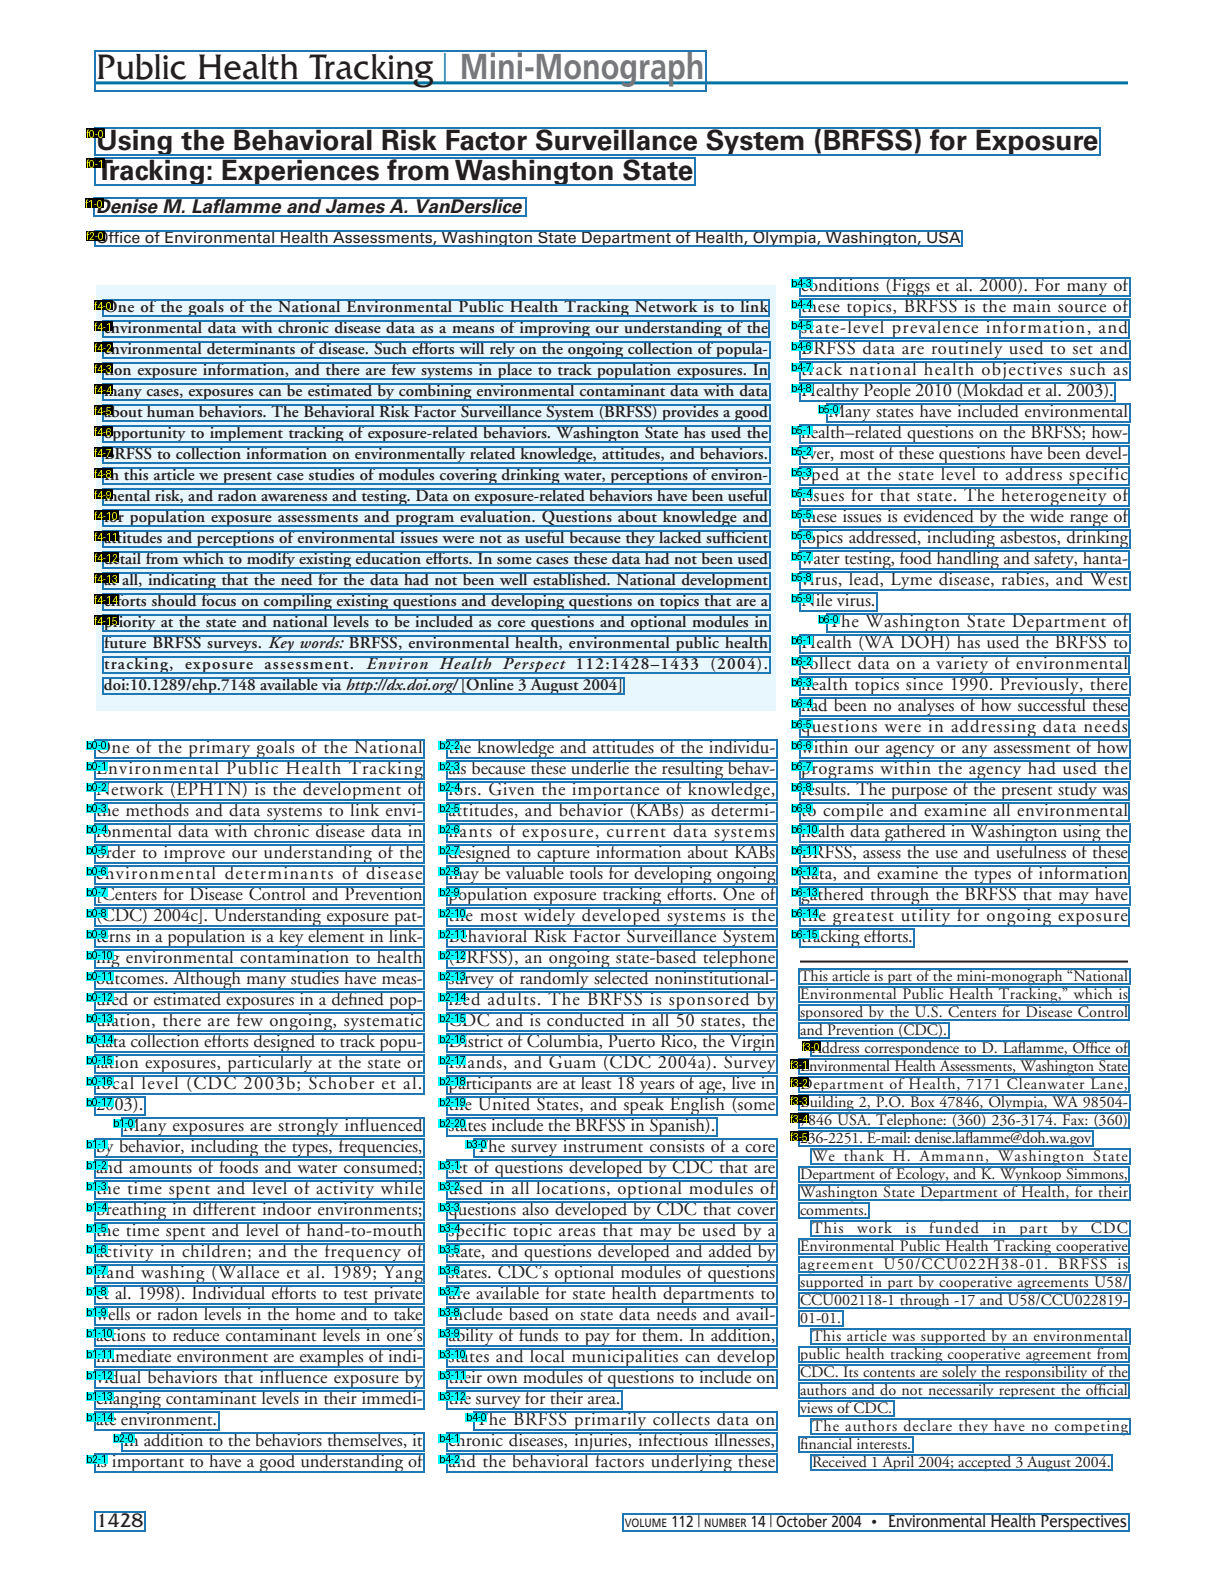

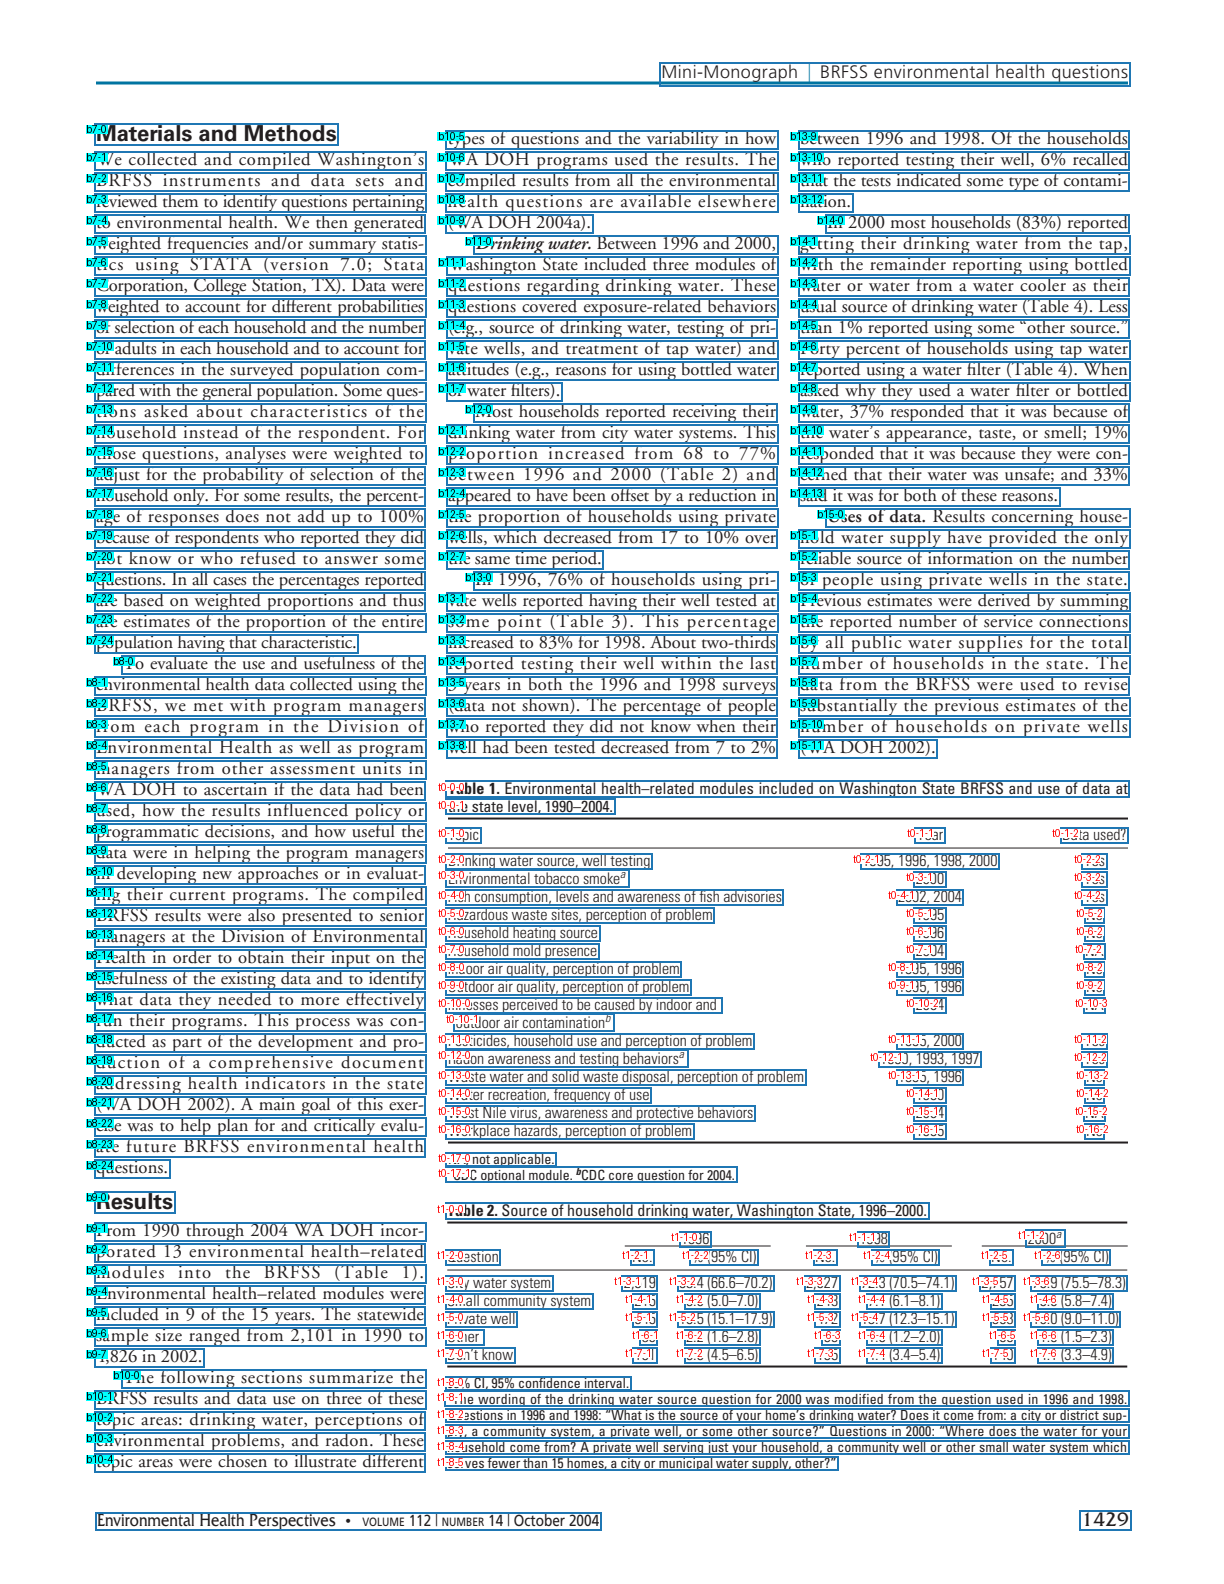

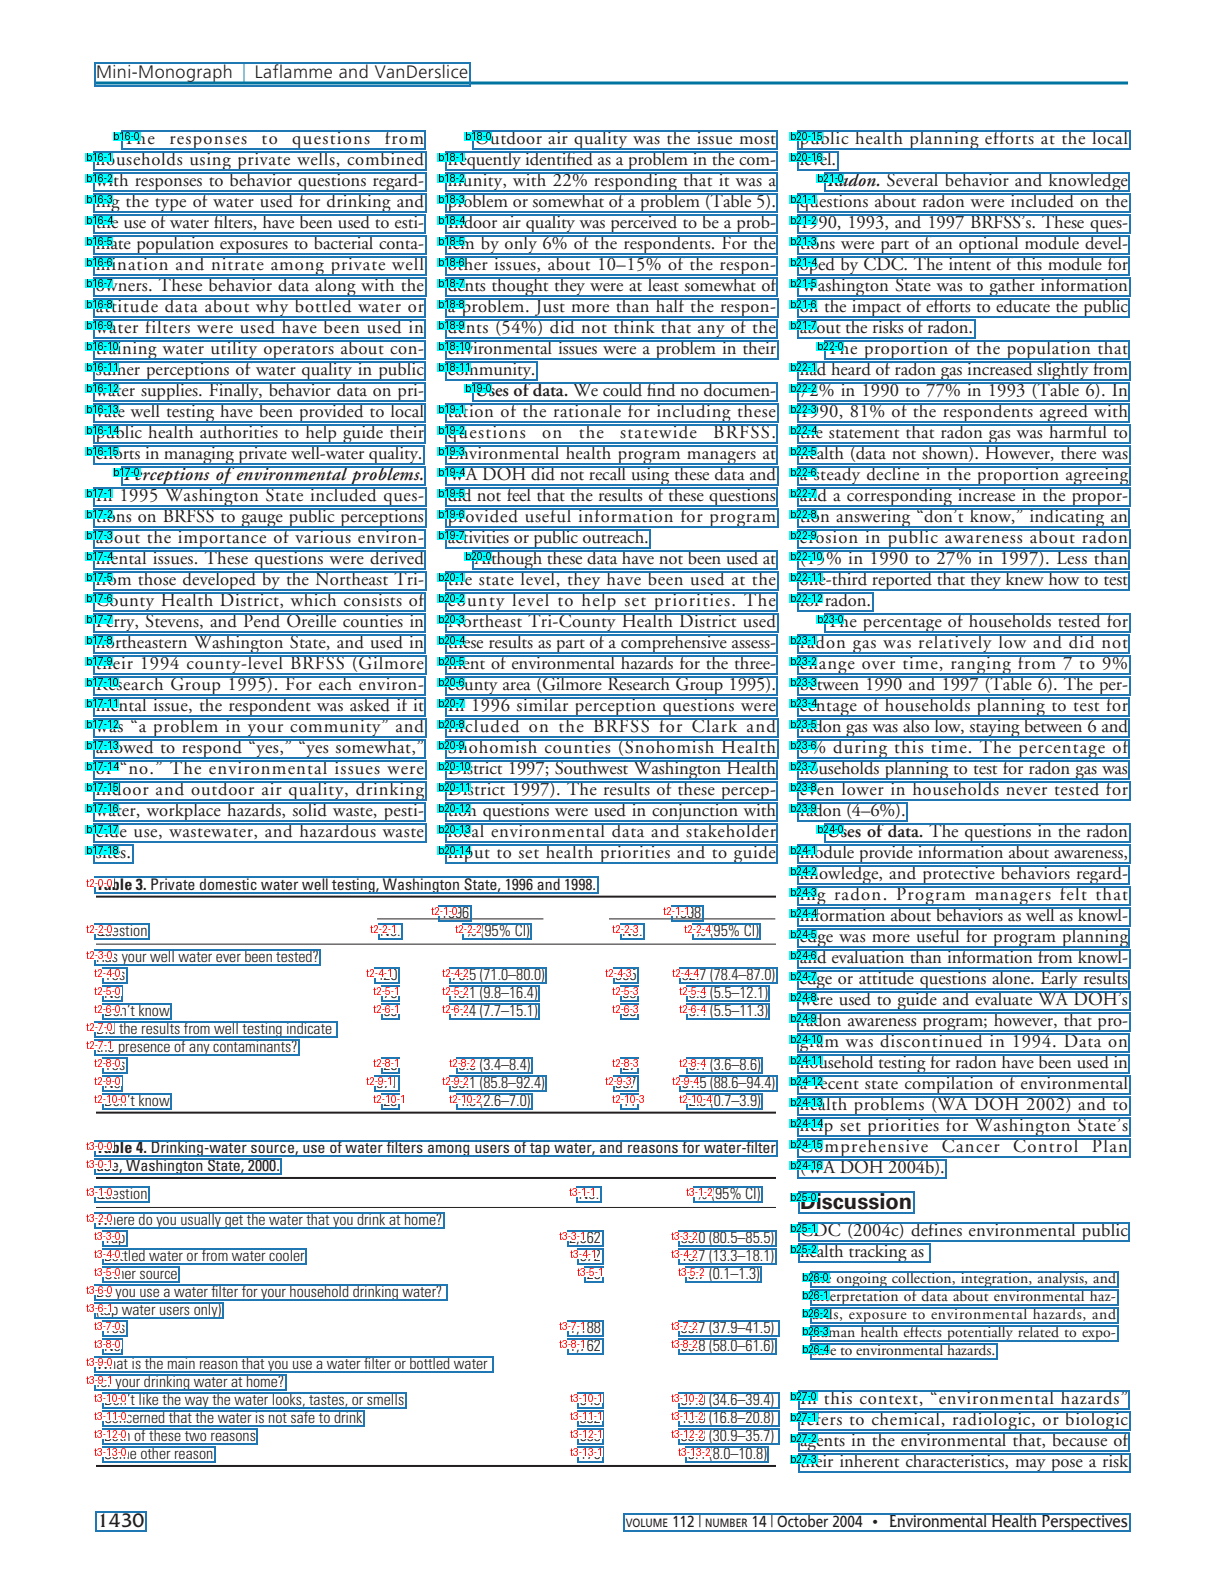

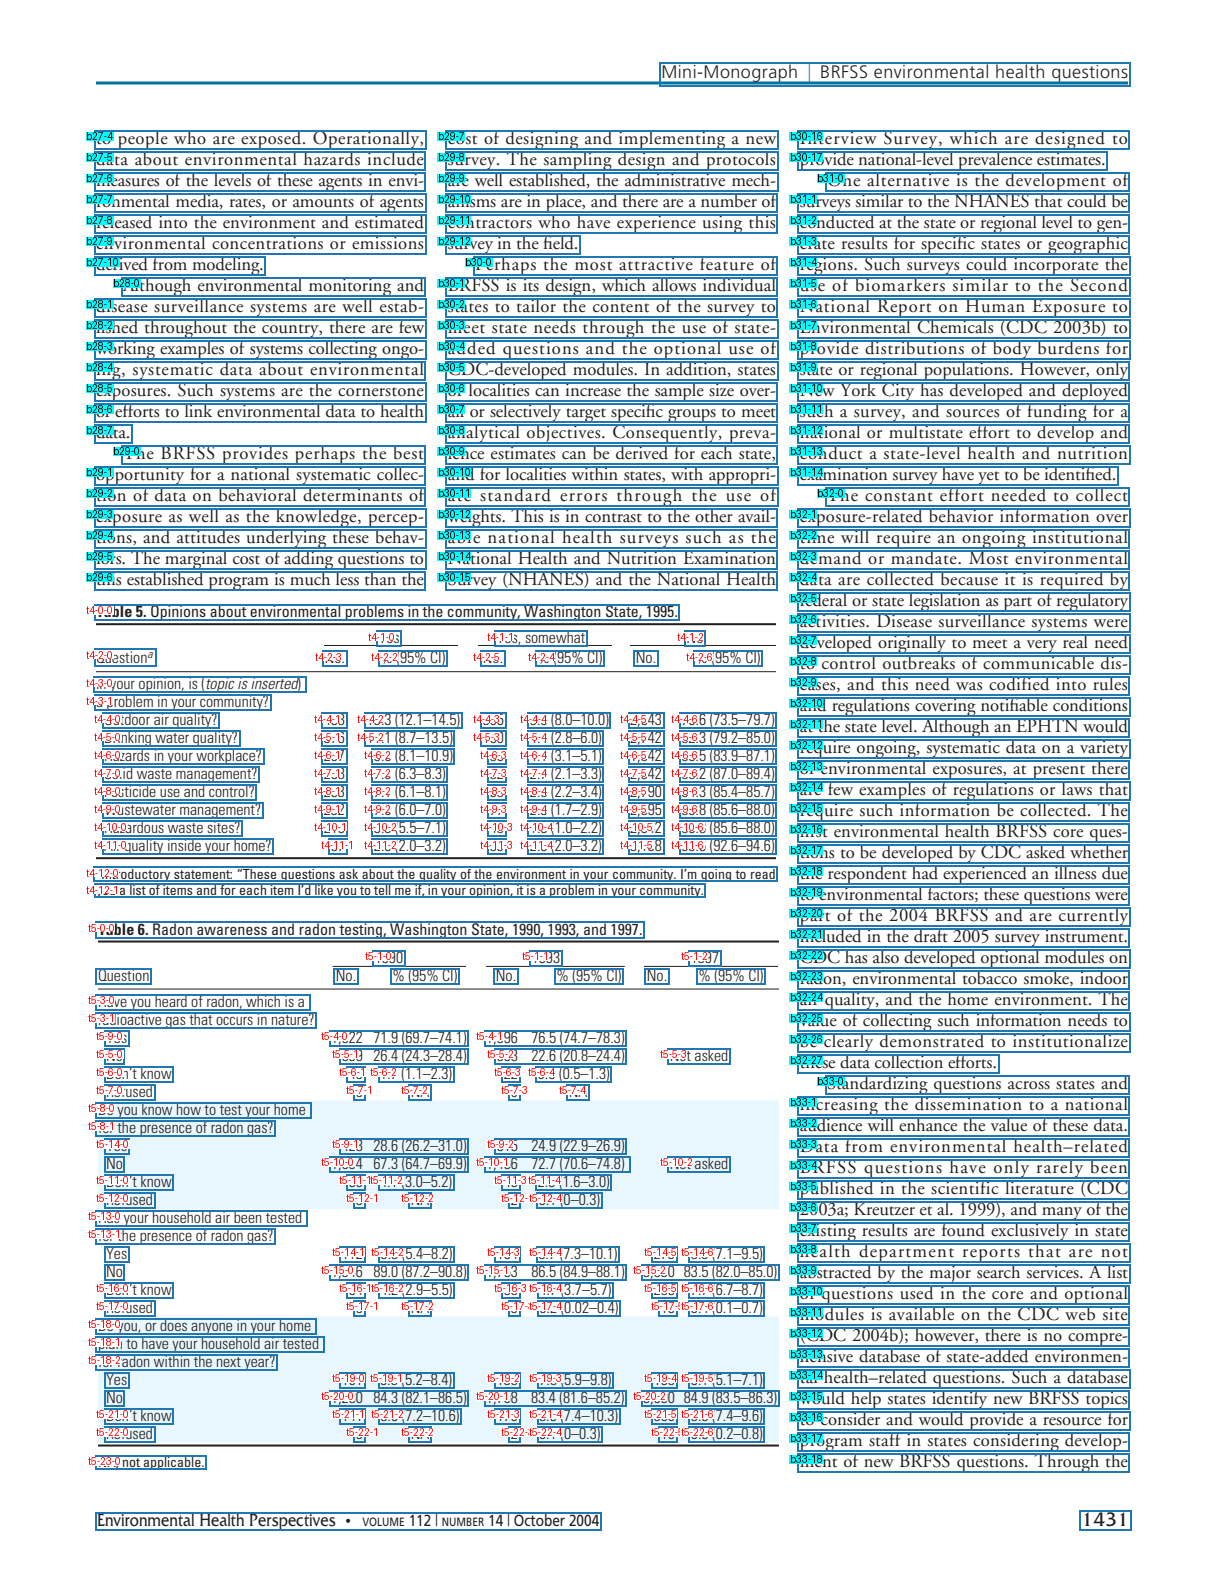

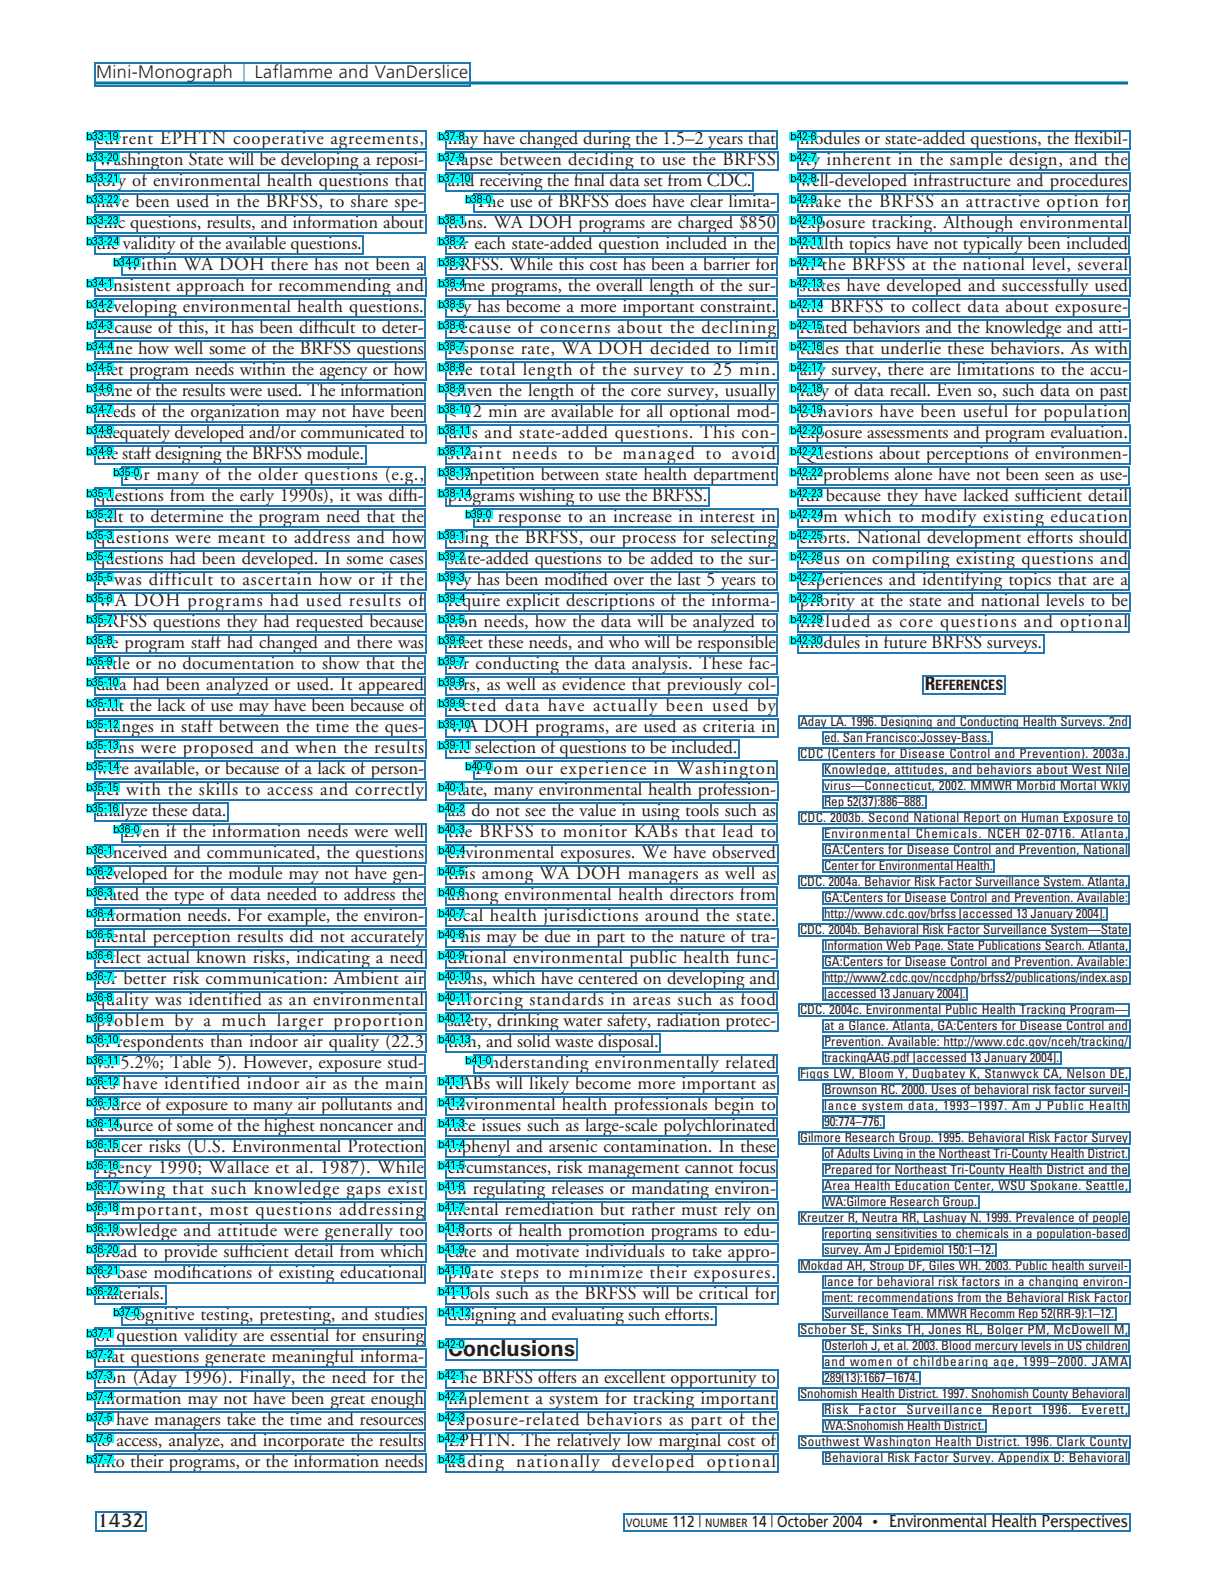

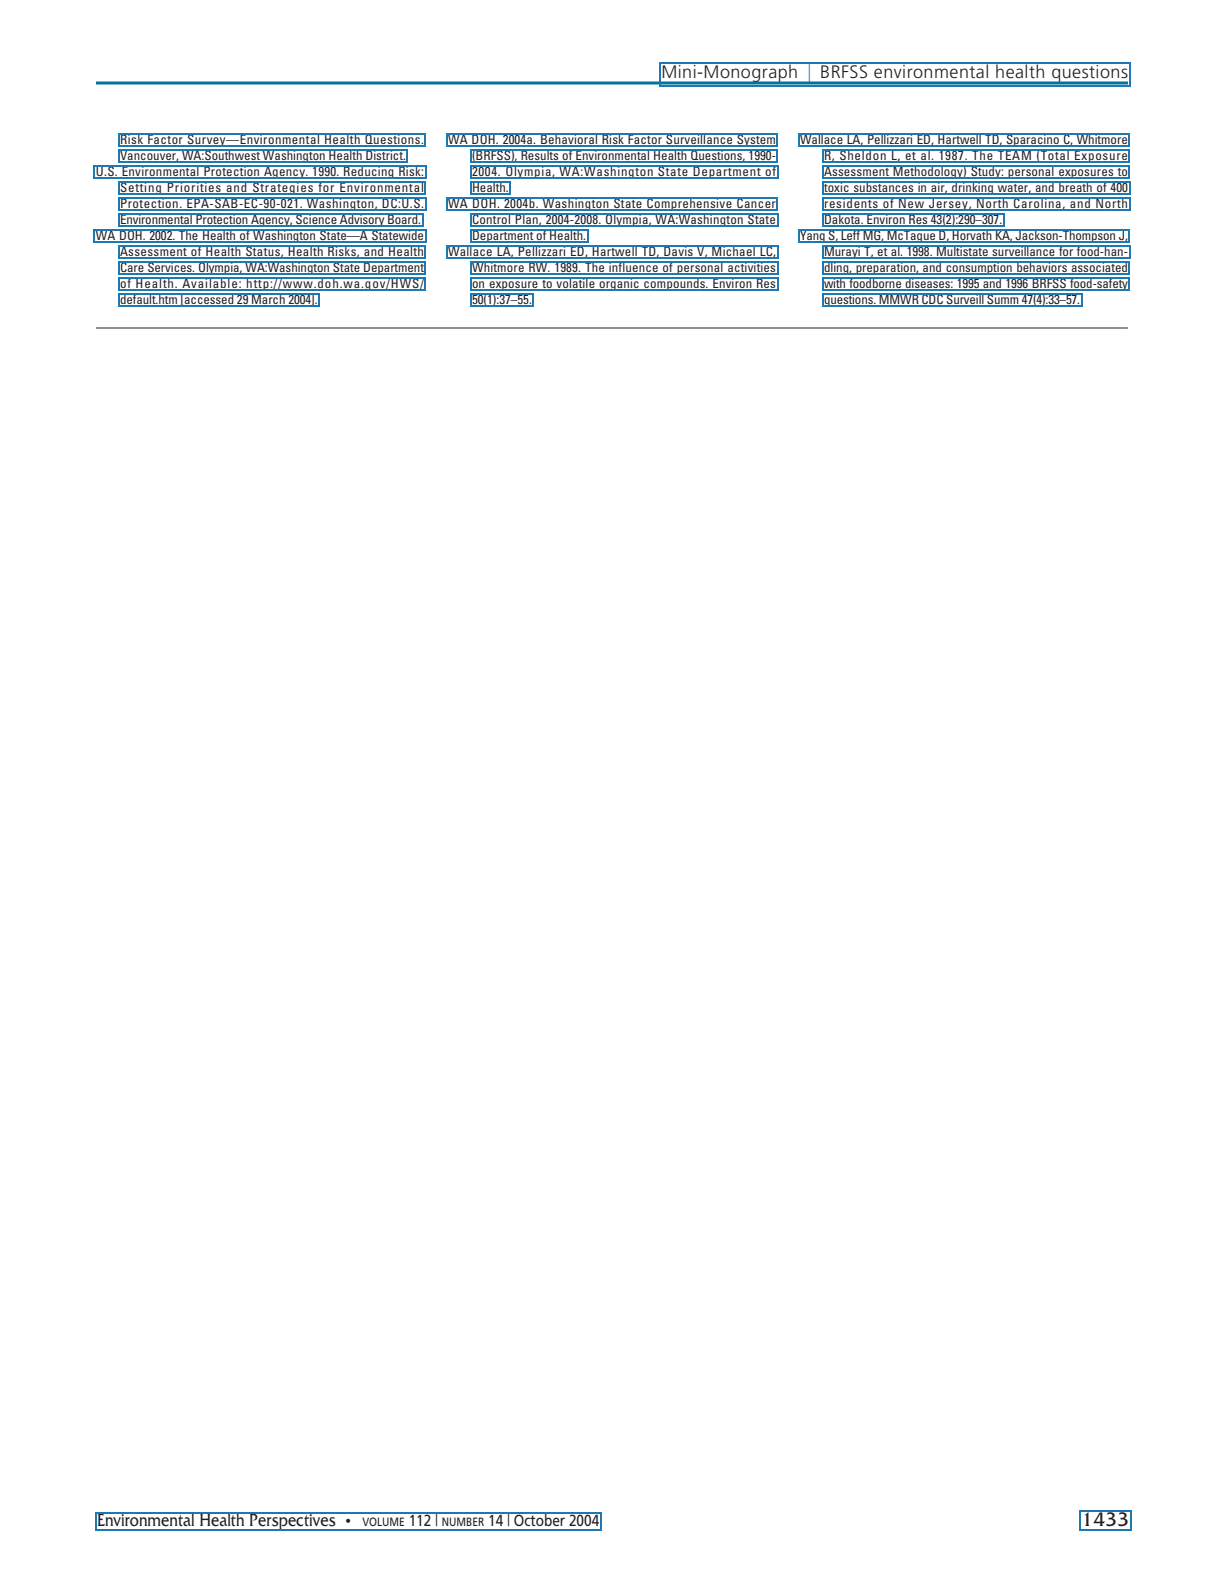

In [134]:
for page in show_annotations(doc.content, doc.content_boxes):
    display(page)